In [1]:
from imports import *
from layers import RandomPixelSwap

In [2]:
#load labels from data
labels = pd.read_csv("abcd_subjid_rfmricount_sc_age_sex_totalcog.csv",header=0)
print(labels.shape)

(9614, 6)


In [3]:
#prepare ages for linreg
def append_ext(fn):
    return fn+".png"
reglab = pd.read_csv("abcd_subjid_rfmricount_sc_age_sex_totalcog.csv",header=0)
trainframe = reglab[:7800]
testframe = reglab[7799:]
trainframe["id"]=trainframe["id"].apply(append_ext)
testframe["id"]=testframe["id"].apply(append_ext)
trainframe = trainframe.drop(['nihtbx_totalcomp_fc'],axis=1)
testframe.drop(['nihtbx_totalcomp_fc'],axis=1)
trainframe =trainframe.dropna()
testframe=testframe.dropna()
print(len(trainframe))
print(trainframe.isnull().sum())

7798
id             0
rfmri_count    0
sc_count       0
age            0
sex            0
dtype: int64


/var/folders/m1/m63v9zms1l93r38tjn3skdrm0000gn/T/ipykernel_63886/3831864831.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainframe["id"]=trainframe["id"].apply(append_ext)
/var/folders/m1/m63v9zms1l93r38tjn3skdrm0000gn/T/ipykernel_63886/3831864831.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testframe["id"]=testframe["id"].apply(append_ext)


In [4]:
#setup age data

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.11)
x = random.randint(0, 10000)
train_generator=datagen.flow_from_dataframe(
  dataframe=trainframe,
  directory="./images/ageregression/",
  x_col="id",
  y_col="age",
  subset="training",
  batch_size=32,
  color_mode="rgb",
  seed=42,
  shuffle=True,
  class_mode="raw",
  target_size=(86,86)
)
valid_generator=datagen.flow_from_dataframe(
dataframe=trainframe,
directory="./images/ageregression/",
x_col="id",
y_col="age",
color_mode="rgb",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(86,86))
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=testframe,
color_mode="rgb",
directory="./images/ageregression/",
x_col="id",
y_col="age",
batch_size=32,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(86,86))


Found 6936 validated image filenames.
Found 857 validated image filenames.
Found 1674 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


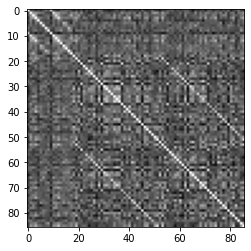

In [5]:
#test image 
plt.imshow(test_generator[1][0][2])

In [35]:
model = keras.Sequential([
    layers.Input(shape=(86,86,3)),
    layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64,activation='tanh'),
    layers.Dense(32,activation='tanh'),
    layers.Dense(1,activation='linear')


    
])


model.compile(
    optimizer='adam',
    loss='mse'
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    
)

Epoch 1/100
217/217 [==============================] - 11s 50ms/step - loss: 6.8602 - val_loss: 0.3948
Epoch 2/100
217/217 [==============================] - 11s 49ms/step - loss: 0.3905 - val_loss: 0.3926
Epoch 3/100
217/217 [==============================] - 11s 51ms/step - loss: 0.3901 - val_loss: 0.3922
Epoch 4/100
217/217 [==============================] - 13s 59ms/step - loss: 0.3899 - val_loss: 0.3922
Epoch 5/100
217/217 [==============================] - 15s 69ms/step - loss: 0.3901 - val_loss: 0.3924
Epoch 6/100
217/217 [==============================] - 14s 67ms/step - loss: 0.3900 - val_loss: 0.3922
Epoch 7/100
217/217 [==============================] - 13s 60ms/step - loss: 0.3904 - val_loss: 0.3923
Epoch 8/100
217/217 [==============================] - 14s 67ms/step - loss: 0.3906 - val_loss: 0.3940
Epoch 9/100
217/217 [==============================] - 15s 67ms/step - loss: 0.3905 - val_loss: 0.3926
Epoch 10/100
217/217 [==============================] - 15s 68ms/step - l

dict_keys(['loss', 'val_loss'])


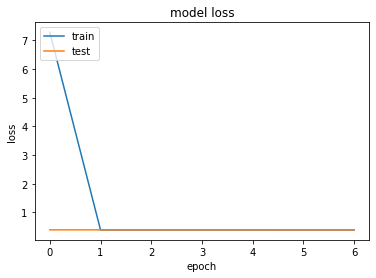

In [34]:
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
from sklearn.metrics import r2_score

predicted_ages = np.squeeze(model.predict(test_generator))
true_ages = test_generator.labels

rmse = np.sqrt(model.evaluate(test_generator, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(true_ages, predicted_ages)
print("Test R^2 Score: {:.5f}".format(r2))


53/53 [==============================] - 1s 20ms/step
     Test RMSE: 0.63366
Test R^2 Score: -0.00021


In [6]:
print(os.getcwd())
x = random.randint(0, 10000)
train_data  = keras.utils.image_dataset_from_directory(
  directory = os.getcwd()+'/images/abcd_FC_fs86_9609subj/',
  validation_split=0.11,
  subset="training",
  color_mode='grayscale',
  seed=42,
  image_size=(86, 86),
  batch_size=32,
)
val_data  = keras.utils.image_dataset_from_directory(
  directory = os.getcwd()+'/images/abcd_FC_fs86_9609subj/',
  validation_split=0.11,
  subset="validation",
  seed=42,
  color_mode='grayscale',
  image_size=(86, 86),
  batch_size=32,
)
test_data = keras.utils.image_dataset_from_directory(
  directory = os.getcwd()+'/images/train/',
  color_mode='grayscale',
  image_size=(86, 86),
  batch_size=32,
)

/Users/gabesmall/Documents/ABCD - Neuronetworking
Found 7689 files belonging to 2 classes.
Using 6844 files for training.
Found 7689 files belonging to 2 classes.
Using 845 files for validation.
Found 1920 files belonging to 2 classes.


In [8]:
class_names = train_data.class_names
print(class_names)
for images, labels in train_data.take(1):
  print(labels)

['female', 'male']
tf.Tensor([0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0], shape=(32,), dtype=int32)


In [22]:
Model_Checkpoint = keras.callbacks.ModelCheckpoint(
    'modelsave.h5', # You also can provide full path to the folder you want to save your model to
    monitor='val_binary_accuracy',  # Monitor other things like val_accuracy or accuracy 
    save_best_only='True', # Make sure to save only the best model
    verbose=0
)
Early_Stopping = keras.callbacks.EarlyStopping(
    monitor='val_binary_accuracy', # Same as the 
    patience=5, # Wait for 5 epochs before stopping the training
    verbose=1,
    restore_best_weights='True', # Restore model weights from the epoch with the best value of the monitored quantity.
    min_delta=0.02
)

In [30]:
reg =keras.regularizers.l2(0.0001)

model = keras.Sequential([
        keras.Input(shape=(86,86,1)),
        keras.layers.Rescaling(1./255),
        layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation="tanh",kernel_regularizer=reg),
        layers.MaxPool2D(),
        layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation="tanh",kernel_regularizer=reg),
        layers.MaxPool2D(),
        layers.Flatten(),
        layers.Dense(64,activation="tanh", name="layer2",kernel_regularizer=reg),
        layers.Dropout(rate=0.15),
        layers.Dense(32,activation="tanh", name="layer1",kernel_regularizer=reg),
        layers.Dropout(rate=0.3),
        layers.Dense(1,activation="sigmoid", name="layer3")      
        
    ]
)

model.summary()
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

history = model.fit(train_data,epochs=150,validation_data=val_data,shuffle=True,callbacks=[Early_Stopping,Model_Checkpoint])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 86, 86, 1)         0         
                                                                 
 conv2d_31 (Conv2D)          (None, 86, 86, 32)        320       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 43, 43, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 21, 21, 64)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 28224)           

60/60 [==============================] - 1s 19ms/step - loss: 0.5333 - binary_accuracy: 0.7573
[0.5332890748977661, 0.7572916746139526]
60/60 [==============================] - 1s 20ms/step


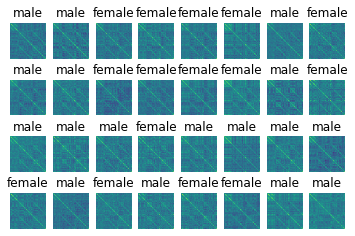

In [31]:

print(model.evaluate(test_data))
pred = model.predict(test_data) 
for images, labels in test_data.take(1):
 
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(test_data.class_names[round(pred[i][0])])
    plt.axis("off")